In [442]:
import random
import gensim
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.decomposition
import sklearn.feature_extraction
import ipywidgets as widgets
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display
from collections import defaultdict


In [443]:
year='2018'
papers=pd.read_csv(f'/Users/supra/study/year2/data-sci/project/CEDT-DS-Project_LittleMermaid/Kafka/output_csv/{year}.csv')

In [ ]:
print(papers.shape)
papers['Title'] = papers['Title'].fillna('Untitled').str.strip()

(3993, 8)
(3993, 8)


In [445]:
def prepare_fig(w=1, h=None):
    if h is None: h = w
    figsize = (6 * w, 3 * h)
    sns.set(rc={'figure.figsize': figsize})
    fig = plt.figure(figsize=figsize)
    plt.clf()
    return fig

def top_k(mapping, k=10):
    return sorted(mapping.keys(), key=lambda x: mapping[x])[::-1][:k]

pd.set_option('display.max_rows', 250)

In [446]:
papers.head()

,Title,Abstract,Author,Aggregation_Type,Publisher,Publication_Date,Institutions,Keywords
0,Public health and international epidemiology f...,NaN,Pongpirul K.; Lungren M.P.,Book,Springer International Publishing,2018-12-31,Chulalongkorn University; Johns Hopkins Bloomb...,NaN
1,Flexible Printed Active Antenna for Digital Te...,"© 2018 The Institute of Electronics, Informati...",Pratumsiri T.; Janpugdee P.,Conference Proceeding,Institute of Electrical and Electronics Engine...,2018-12-31,Chulalongkorn University,NaN
2,Parametric study of hydrogen production via so...,© 2018 Elsevier LtdComputational fluid dynamic...,Phuakpunk K.; Chalermsinsuwan B.; Putivisutisa...,Journal,Elsevier Ltd,2018-12-31,Chulalongkorn University; Chulalongkorn Univer...,Circulating fluidized bed; Computational fluid...
3,Superhydrophobic coating from fluoroalkylsilan...,© 2018 Elsevier B.V. A superhydrophobic/supero...,Saengkaew J.; Le D.; Samart C.; Sawada H.; Nis...,Journal,Elsevier B.V.,2018-12-31,Thammasat University; Hirosaki University; Nat...,Encapsulation; Fluoroalkylsilane; Natural rubb...
4,Electrochemical impedance-based DNA sensor usi...,© 2018 Elsevier B.V. A label-free electrochemi...,Teengam P.; Siangproh W.; Tuantranont A.; Vila...,Journal,Elsevier B.V.,2018-12-31,Chulalongkorn University; Srinakharinwirot Uni...,acpcPNA; Electrochemical impedance spectroscop...


In [447]:
papers['Abstract'][4]

'© 2018 Elsevier B.V. A label-free electrochemical DNA sensor based on pyrrolidinyl peptide nucleic acid (acpcPNA)-immobilized on a paper-based analytical device (PAD) was developed. Unlike previous PNA-based electrochemical PAD (ePAD) sensors where the capture element was placed directly on the electrode, acpcPNA was covalently immobilized onto partially oxidized cellulose paper allowing regeneration by simple PAD replacement. As an example application, a sensor probe was designed for Mycobacterium tuberculosis (MTB) detection. The ePAD DNA sensor was used to determine a synthetic 15-base oligonucleotide of MTB by measuring the fractional change in the charge transfer resistance (R ct ) obtained from electrochemical impedance spectroscopy (EIS). The R ct of [Fe(CN) 6 ] 3-/4- before and after hybridization with the target DNA could be clearly distinguished. Cyclic voltammetry (CV) was used to verify the EIS results, and showed an increase in peak potential splitting in a similar stepwi

In [448]:
print(len(papers))

3993


In [449]:
texts = []
for i in range(len(papers)):
    title = str(papers['Title'][i]) if not pd.isna(papers['Title'][i]) else ''
    abstract = str(papers['Abstract'][i]) if not pd.isna(papers['Abstract'][i]) else ''
    text = title + ' ' + abstract
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9]', ' ', text) # Replace punctation by spaces
    texts.append([w for w in text.split(' ') if w]) # Split on spaces, remove empty items

print(texts[1])

['flexible', 'printed', 'active', 'antenna', 'for', 'digital', 'television', 'reception', '2018', 'the', 'institute', 'of', 'electronics', 'information', 'and', 'communication', 'engineers', 'ieice', 'this', 'paper', 'presents', 'the', 'development', 'of', 'a', 'flexible', 'printed', 'active', 'antenna', 'for', 'the', 'digital', 'television', 'dtv', 'reception', 'in', 'areas', 'having', 'poor', 'signal', 'or', 'in', 'high', 'rise', 'buildings', 'the', 'antenna', 'structure', 'is', 'composed', 'of', 'a', 'meander', 'line', 'printed', 'on', 'a', 'polyimide', 'film', 'as', 'a', 'radiating', 'element', 'it', 'has', 'a', 'thickness', 'of', '0', '3', 'mm', 'highly', 'flexible', 'and', 'very', 'lightweight', 'the', 'design', 'and', 'analysis', 'of', 'the', 'radiating', 'element', 'are', 'based', 'on', 'a', 'full', 'wave', 'method', 'implemented', 'by', 'a', 'commercial', 'electromagnetic', 'simulation', 'software', 'the', 'amplifier', 'circuit', 'consisting', 'of', 'a', 'surface', 'mount', 't

In [450]:
import logging
# Load stopwords, bigrams, and stem rules
try:
    stopwords = set()
    with open('stopwords.txt', 'r') as f:
        stopwords = [w.strip() for w in f if w.strip()]
                
    print('loaded {} stopwords'.format(len(stopwords)))
except Exception as e:
    logging.error('failed to load stopwords.txt: {}'.format(e))

try:
    bigrams = dict()
    with open('bigrams.txt', 'r') as f:
        for line in f:
            if line.strip():
                a, b, c = line.split()
                bigrams[a, b] = c
        
    print('loaded {} bigrams'.format(len(bigrams)))
except Exception as e:
    logging.error('failed to load bigrams.txt: {}'.format(e))
    
try:
    stem_rules = dict()
    with open('stemming.txt', 'r') as f:
        for line in f:
            if line.strip():
                a, b = line.strip().split()
                stem_rules[a] = b
        
    print('loaded {} stem rules'.format(len(stem_rules)))
except Exception as e:
    logging.error('failed to load stemming.txt: {}'.format(e))

loaded 173 stopwords
loaded 97 bigrams
loaded 3 stem rules


In [451]:
# Print common words
one_count = defaultdict(int)

for text in texts:
    for a in text:
        one_count[a] += 1
     
print('Top words')
display(pd.DataFrame(
    [(w, one_count[w], 'Yes' * (w in stopwords)) for w in top_k(one_count, 250)],
    columns=['word', 'count', 'in stopwords.txt?']))



Top words


,word,count,in stopwords.txt?
0,the,49276,Yes
1,of,36189,Yes
2,and,33852,Yes
3,in,20777,Yes
4,to,17459,Yes
5,a,13758,
6,for,9297,Yes
7,with,8243,Yes
8,is,6708,Yes
9,on,5731,Yes


In [452]:
# Print common bigrams
two_count = defaultdict(int)

for text in texts:
    for a, b in zip(text, text[1:]):
        if a not in stopwords and b not in stopwords:
            two_count[a, b] += 1
            
print('Top bigrams')
display(pd.DataFrame(
    [(w, two_count[w], 'Yes' * (w in bigrams)) for w in top_k(two_count, 250)],
    columns=['bigram', 'count', 'in bigrams.txt?']))

Top bigrams


,bigram,count,in bigrams.txt?
0,"(p, 0)",719,
1,"(rights, reserved)",446,
2,"(95, ci)",340,
3,"(author, s)",291,
4,"(2018, elsevier)",267,
5,"(0, 05)",207,
6,"(0, 001)",206,
7,"(b, v)",193,
8,"(proton, proton)",192,
9,"(elsevier, b)",166,


In [453]:
# Merge bigrams
for text in texts:
    i = 0
    
    while i < len(text) - 1:
        a, b = text[i], text[i + 1]
        
        if (a, b) in bigrams:
            text[i:i+2] = [bigrams[a,b]]
        else:
            i += 1

In [454]:
# Filter tokens
def filter_texts(texts, f):
    return [[token for token in text if f(token)] for text in texts] 

texts = filter_texts(texts, lambda t: t not in stopwords) # Filter stopwords
texts = filter_texts(texts, lambda t: len(t) > 1) # Remove single char words 
texts = filter_texts(texts, lambda t: not re.match('^[0-9]+$', t)) # Remove numbers

In [455]:
# Stemming
stemmer = gensim.parsing.PorterStemmer()
word_count = defaultdict(int)
stemming = dict()
unstemming = dict()


# Stem each word and count "word, stem" pairs
for text in texts:
    for token in text:
        word_count[token] += 1
    
# Sorted stems by frequency, the value for unstemming[stem] is overwritten 
# and should be the one with the highest count.
for token in sorted(word_count.keys(), key=word_count.get):
    stem = stemmer.stem(token)
    stemming[token] = stem
    unstemming[stem] = token

# Overwrite with user defined rules
for a, b in stem_rules.items():
    stemming[a] = b
    unstemming[b] = b

# Stem words
stemmed_texts = [[unstemming[stemming[token]] for token in text] for text in texts]

logging.info('stemming reduced {} to {} tokens'.format(len(stemming), len(unstemming)))
pd.DataFrame(
    [(
        token, 
        stemming[token], 
        unstemming[stemming[token]], 
        word_count[token]
    ) for token in top_k(word_count, k=250)],
    columns=['Original', 'Stem', 'Unstem', 'Count'])

,Original,Stem,Unstem,Count
0,research,research,research,2743
1,innovation,innov,innovation,2113
2,engineering,engin,engineering,1663
3,development,develop,development,1561
4,data,data,data,1535
5,analysis,analysi,analysis,1523
6,patients,patient,patients,1469
7,model,model,model,1425
8,technology,technolog,technology,1358
9,group,group,group,913


In [456]:
# Remove papers with less than 25 words after preprocessing
n = len(papers)
indices = [i for i in range(len(papers)) if len(stemmed_texts[i]) > 25]
papers = papers.iloc[indices]
final_texts = [stemmed_texts[i] for i in indices]

print('papers: {} (removed {})'.format(len(papers), n - len(papers)))

papers: 3875 (removed 118)


In [457]:
dic = gensim.corpora.Dictionary(final_texts)
dic.filter_extremes(0, 0.5) # Remove 
dic.filter_extremes(5, 1)   # 
corpus = [dic.doc2bow(text) for text in final_texts]

print('papers: {}'.format(len(corpus)))
print('dictionary size: {}'.format(len(dic)))

papers: 3875
dictionary size: 5743


In [458]:
# Create frequency matrix
n, m = len(corpus), len(dic)
matrix = np.zeros((n, m))

for i, row in enumerate(corpus):
    for j, freq in row:
        matrix[i,j] = freq

In [459]:
num_topics = 12
seed = 7

tfidf_model = sklearn.feature_extraction.text.TfidfTransformer()
tfidf_matrix = tfidf_model.fit_transform(matrix).toarray()
nmf_model = sklearn.decomposition.NMF(
    n_components=num_topics,
    random_state=seed,
    tol=1e-9,
    max_iter=500,
    verbose=True)

# Train model
doc2topic = nmf_model.fit_transform(tfidf_matrix)
topic2token = nmf_model.components_

topic_norm = np.sum(topic2token, axis=1)
topic2token /= topic_norm[:,np.newaxis]
doc2topic *= topic_norm[np.newaxis,:]

doc_norm = np.sum(doc2topic, axis=1)
doc2topic /= doc_norm[:,np.newaxis]

violation: 1.0
violation: 0.1980431610712464
violation: 0.1089008183271485
violation: 0.0694725513379886
violation: 0.051154577366275565
violation: 0.04177288849023417
violation: 0.03702235134365032
violation: 0.032800826427874415
violation: 0.02731866901705777
violation: 0.02158962439666123
violation: 0.016869339667359307
violation: 0.013682518134704749
violation: 0.01175360206963798
violation: 0.010433992992143185
violation: 0.009426888241200462
violation: 0.00858367527268081
violation: 0.007883280433081874
violation: 0.007260853453757548
violation: 0.0066916560092059405
violation: 0.0061691102102065624
violation: 0.0056778464233472395
violation: 0.005217686727243349
violation: 0.004798204554326897
violation: 0.004389781913854429
violation: 0.004005124654500991
violation: 0.0035762531659641445
violation: 0.003158544646532669
violation: 0.0027887512357493327
violation: 0.0024669416695359855
violation: 0.002189378824328014
violation: 0.0019465655688551886
violation: 0.00173474709725834

In [460]:
rows = []
labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
for label, vec in zip(labels, topic2token):
    rows.append([label] + ['{} ({:.2})'.format(dic[i], vec[i]) for i in np.argsort(vec)[::-1][:10]])

# Each row is a topic, columns are words ordered by weight 
pd.DataFrame(rows)

,0,1,2,3,4,5,6,7,8,9,10
0,A,engineering (0.037),project (0.018),research (0.016),development (0.012),university (0.0092),program (0.0082),science (0.0069),construction (0.0064),challenges (0.0051),course (0.005)
1,B,proton (0.033),decay (0.023),mass (0.023),tev (0.021),boson (0.021),quark (0.021),collisions (0.021),search (0.018),jet (0.016),pair (0.014)
2,C,patients (0.028),group (0.0095),treatment (0.0078),disease (0.0066),clinical (0.0059),outcomes (0.0057),risk (0.0056),ci (0.0054),control (0.0047),therapy (0.0046)
3,D,catalyst (0.0085),acid (0.0068),carbon (0.0066),temperature (0.0057),water (0.0051),tio2 (0.0051),properties (0.005),surface (0.0048),composite (0.0048),oil (0.0046)
4,E,cells (0.034),cancer (0.014),protein (0.012),activity (0.011),expression (0.01),compounds (0.0068),induced (0.0067),lung (0.0052),cytotoxicity (0.0052),against (0.0052)
5,F,learning (0.06),teaching (0.02),teachers (0.017),course (0.016),educational (0.011),student (0.011),skills (0.011),school (0.0091),learners (0.0087),activity (0.0084)
6,G,model (0.01),algorithm (0.0068),data (0.0062),simulation (0.0059),network (0.0049),technique (0.0049),computer (0.0044),performance (0.0043),image (0.0041),analysis (0.0038)
7,H,species (0.019),isolated (0.015),gene (0.012),strain (0.011),sequence (0.0095),dna (0.0087),sp (0.008),genus (0.0066),genome (0.0063),resistance (0.0063)
8,I,service (0.032),business (0.029),model (0.018),production (0.013),management (0.01),digital (0.01),customer (0.01),sustainable (0.0093),companies (0.0092),manufacturing (0.0091)
9,J,technology (0.067),industry (0.015),development (0.013),research (0.011),science (0.0082),energy (0.0078),innovation (0.0071),management (0.0063),patents (0.0055),manufacturing (0.0053)


In [476]:
#PUREM TEST1
# # สร้างข้อมูลจาก topic2token
# rows = []
# labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
# for label, vec in zip(labels, topic2token):
#     # สำหรับแต่ละหัวข้อ (topic) นำคำและค่า (word and weight) มาจัดเรียง
#     rows.append([label] + ['{} ({:.4f})'.format(dic[i], vec[i]) for i in np.argsort(vec)[::-1][:]])

# # สร้าง DataFrame
# topic_df = pd.DataFrame(rows)

# topic_df.to_csv(f'../DA/VisualizeData/{year}_Topic.csv', index=False ,  header=False )

# # แสดงข้อมูลใน DataFrame
# print(topic_df)

# สร้างข้อมูลจาก topic2token (แสดงแค่คำที่มีน้ำหนักสูงสุด 3 คำ)
rows = []
labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

for label, vec in zip(labels, topic2token):
    # สำหรับแต่ละหัวข้อ (topic) นำคำและค่า (word and weight) มาจัดเรียง
    row = [label]
    for i in np.argsort(vec)[::-1][:3]:  # แสดงแค่คำที่มีน้ำหนักสูงสุด 3 คำ
        word = dic[i]
        value = vec[i]
        row.append(f"{word} ({value:.4f})")  # จัดรูปแบบให้คำกับค่ามีรูปแบบเช่น 'คำ (ค่าความสำคัญ)'
    rows.append(row)

# เปลี่ยน rows ให้เป็น DataFrame

topic_df = pd.DataFrame(rows, columns=['Topic'] + ['Top 1', 'Top 2', 'Top 3'])
#topic_df.to_csv(f'../DA/VisualizeData/{year}_Topic.csv'  )


# แสดง Top 20 คำจากแต่ละหัวข้อ (โดยไม่ต้องแสดงค่าน้ำหนัก)
rows = []
labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

for label, vec in zip(labels, topic2token):
    # สำหรับแต่ละหัวข้อ (topic), เอาคำที่มีน้ำหนักสูงสุด 20 คำ
    top_words = [dic[i] for i in np.argsort(vec)[::-1][:20]]  # เลือกคำ 20 คำที่มีน้ำหนักสูงสุด
    rows.append([label] + top_words)

# เปลี่ยน rows ให้เป็น DataFrame
topic_df = pd.DataFrame(rows, columns=['Topic'] + [f'Top {i+1}' for i in range(20)])

# แสดงผล DataFrame
print(topic_df)
topic_df.to_csv(f'../DA/VisualizeData/{year}_Topic.csv'  )

   Topic        Top 1      Top 2        Top 3        Top 4        Top 5  \
0      A  engineering    project     research  development   university   
1      B       proton      decay         mass          tev        boson   
2      C     patients      group    treatment      disease     clinical   
3      D     catalyst       acid       carbon  temperature        water   
4      E        cells     cancer      protein     activity   expression   
5      F     learning   teaching     teachers       course  educational   
6      G        model  algorithm         data   simulation      network   
7      H      species   isolated         gene       strain     sequence   
8      I      service   business        model   production   management   
9      J   technology   industry  development     research      science   
10     K       health    factors          age         care   associated   
11     L   innovation      firms    knowledge     research  enterprises   

        Top 6       Top 

Topic 0 (A)
Topic 1 (B)
Topic 2 (C)
Topic 3 (D)
Topic 4 (E)
Topic 5 (F)
Topic 6 (G)
Topic 7 (H)
Topic 8 (I)
Topic 9 (J)
Topic 10 (K)
Topic 11 (L)


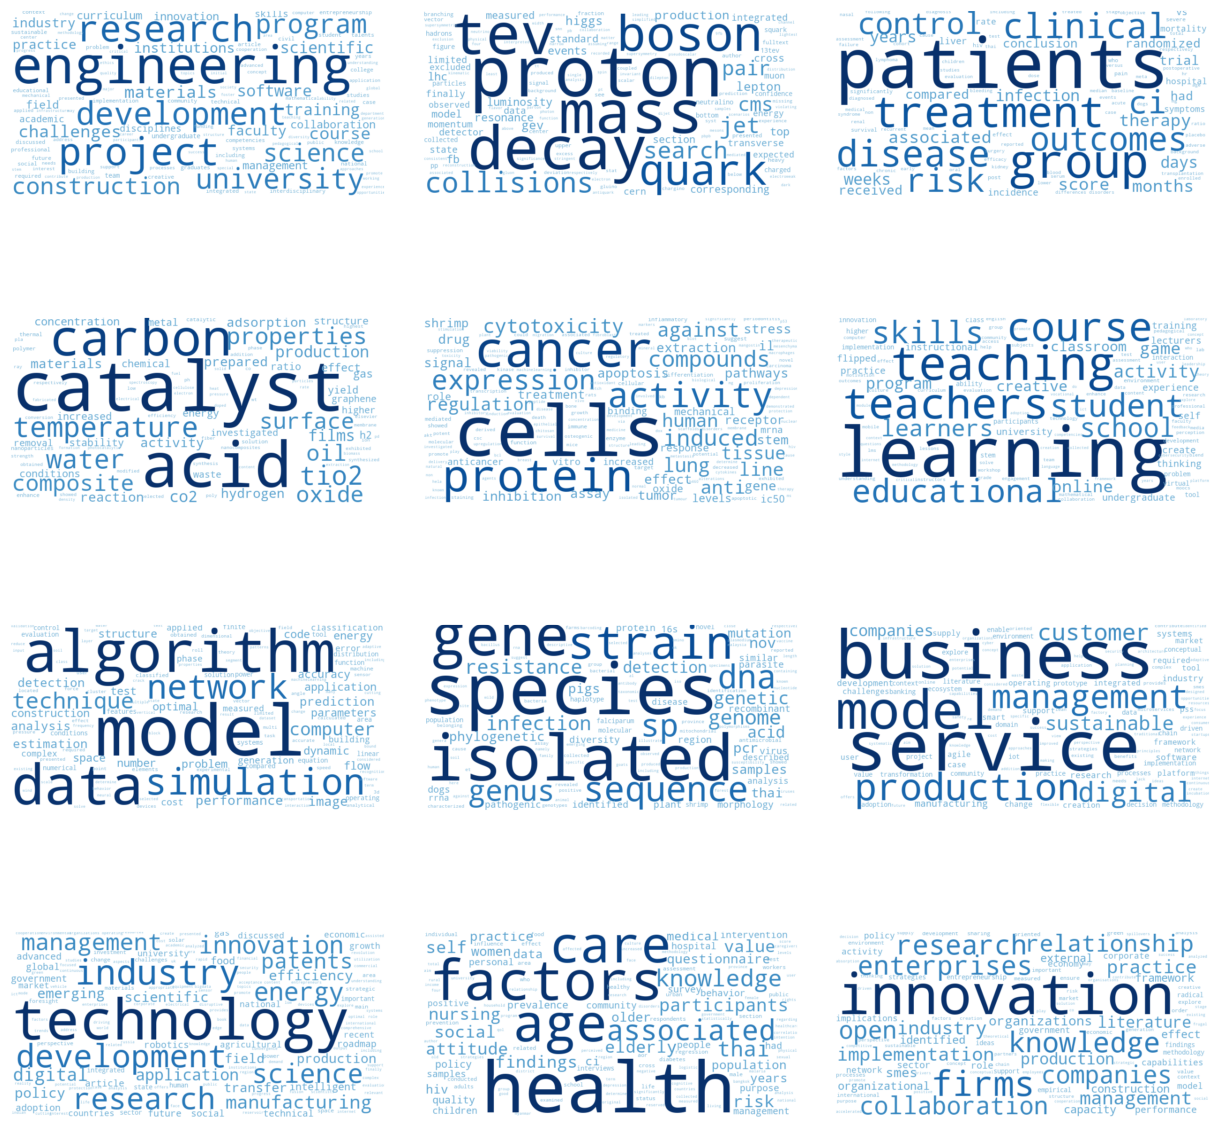

In [462]:
#PUREM TEST2 
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# โหลดข้อมูลจากไฟล์ CSV ที่เราสร้างไว้ก่อนหน้า
topic_df = pd.read_csv(f'../DA/VisualizeData/{year}_Topic.csv', header=None)

# เตรียมการสร้าง visualization
plt.figure(figsize=(12, 12))

# อ่านข้อมูลแต่ละหัวข้อจากไฟล์ CSV
for index in range(len(topic_df)):
    # หัวข้อ (Topic) และคำที่เกี่ยวข้องกับน้ำหนัก
    mapping = {}
    row = topic_df.iloc[index]
    topic_label = row[0]
    words_and_weights = row[1:]

    # สร้าง mapping ของคำและน้ำหนักจากข้อมูล
    for word_and_weight in words_and_weights:
        word, weight = word_and_weight.split('(')
        weight = float(weight.replace(')', '').strip())  # แปลงค่าของน้ำหนัก
        mapping[word] = weight
    
    # ฟังก์ชันเพื่อกำหนดสีใน word cloud
    def get_color(word, **kwargs):
        weight = kwargs['font_size'] / 60.0 * 0.6 + 0.4
        r, g, b = plt.get_cmap('Blues')(weight)[:3]
        return 'rgb(%s, %s, %s)' % (int(r * 255), int(g * 255), int(b * 255))

    # สร้าง WordCloud
    wc = WordCloud(
        prefer_horizontal=True,
        max_font_size=75,
        scale=2,
        background_color='white', 
        color_func=get_color, 
        relative_scaling=0.5)
    
    wc.fit_words(mapping)
    
    print(f'Topic {index} ({topic_label})')
    plt.subplot(4, 3, index + 1)
    plt.imshow(wc.to_array(), interpolation='bilinear')
    plt.xticks([])
    plt.yticks([])

# ปรับแต่งการแสดงผล
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0.1)
plt.show()


In [463]:
# prepare_fig(2, 3)
# for index in range(num_topics):
#     mapping = dict()
#     for i in np.argsort(topic2token[index])[::-1][:100]:
#         if topic2token[index,i] > 0:
#             mapping[dic[i]] = topic2token[index,i]
    
#     def get_color(word, **kwargs):
#         weight = kwargs['font_size'] / 60.0 * 0.6 + 0.4
#         r, g, b = plt.get_cmap('Blues')(weight)[:3]
#         return 'rgb(%s, %s, %s)' % (int(r * 255), int(g * 255), int(b * 255))
    
#     wc = WordCloud(
#         prefer_horizontal=True,
#         max_font_size=75,
#         #width=395,
#         #height=250,
#         scale=2,
#         background_color='white', 
#         color_func=get_color, 
#         relative_scaling=0.5)
#     wc.fit_words(mapping)
    
#     print('Topic {} ({})'.format(index, labels[index]))
#     plt.subplot(4, 3, index + 1)
#     plt.imshow(wc.to_array(), interpolation='bilinear')
#     plt.xticks([])
#     plt.yticks([])
    
# plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0.1)
# plt.show()

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 3875 samples in 0.000s...
[t-SNE] Computed neighbors for 3875 samples in 0.241s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3875
[t-SNE] Computed conditional probabilities for sample 2000 / 3875
[t-SNE] Computed conditional probabilities for sample 3000 / 3875
[t-SNE] Computed conditional probabilities for sample 3875 / 3875
[t-SNE] Mean sigma: 0.008516
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.855278
[t-SNE] KL divergence after 1000 iterations: 1.387264


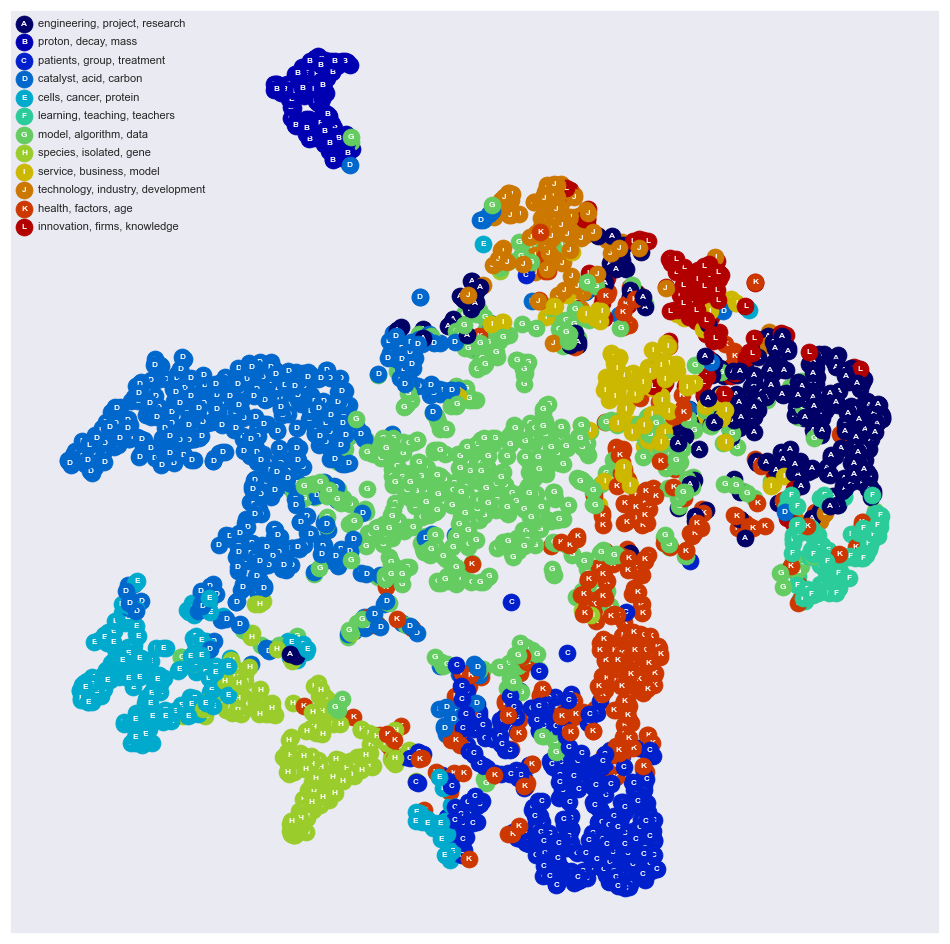

In [464]:
import sklearn.manifold
import sklearn.metrics.pairwise
from sklearn.decomposition import TruncatedSVD
vis_seed = 6
vis_angle = 135

def draw_dot(p, t, zorder=0):
    color = plt.get_cmap('jet')(float(t) / num_topics)
    color = 0.8 * np.array(color)[:3]
    
    plt.scatter(
        p[0], 
        p[1],
        s=150,
        c=[color],
        marker='o',
        linewidth=0.5,
        zorder=zorder)
    
    plt.text(
        p[0], 
        p[1],
        labels[t],
        fontsize=6,
        color='1',
        va='center',
        ha='center',
        fontweight='bold',
        zorder=zorder + 1)

# Lower dimensionality of original frequency matrix to improve cosine distances for visualization
reduced_matrix = TruncatedSVD(
    n_components=10, 
    random_state=seed
).fit_transform(tfidf_matrix)

# Learn model
model = sklearn.manifold.TSNE(
    verbose=True,
    metric='cosine',
    random_state=vis_seed,
    perplexity=20)
pos = model.fit_transform(reduced_matrix)

# Rotate visualization
theta = np.deg2rad(vis_angle + 60)
R = np.array([[np.cos(theta), np.sin(theta)], 
              [-np.sin(theta), np.cos(theta)]])
pos = np.dot(pos, R)

# Resize so xy-position is between 0.05 and 0.95
pos -= (np.amin(pos, axis=0) + np.amax(pos, axis=0)) / 2
pos /= np.amax(np.abs(pos))
pos = (pos * 0.5) + 0.5
pos = (pos * 0.9) + 0.05

prepare_fig(2, 4)
plt.xticks([])
plt.yticks([])
plt.xlim(0, 1)
plt.ylim(0, 1)
zorder = 0

# Draw dots
for i in np.random.permutation(len(doc2topic)):
    topic_id = np.argmax(doc2topic[i])
    draw_dot(pos[i], topic_id, zorder)
    zorder += 2

# Draw legend
for i in range(num_topics):    
    y = 0.985 - i * 0.02
    label = ', '.join(dic[w] for w in np.argsort(topic2token[i])[::-1][:3])

    draw_dot([0.015, y], i)
    plt.text(0.03, y, label, ha='left', va='center', fontsize=8, zorder=zorder)
    zorder += 1

plt.show()

# แต่ละจุด ในกราฟสื่อถึงเอกสาร (หรือคำ) ที่มีการแปลงข้อมูลจากเวกเตอร์หรือการประมวลผลโมเดล Topic Modeling
# ตำแหน่งของจุด บ่งบอกถึงความคล้ายคลึงกันหรือความแตกต่างระหว่างเอกสารเหล่านั้น
# สีและขนาด ช่วยให้มองเห็นการแยกหัวข้อและความสำคัญของเอกสาร
# การกระจายตัว จะช่วยให้เห็นกลุ่มของเอกสารที่มีความคล้ายคลึงกันในหัวข้อเดียวกัน

In [465]:
def on_select(i):
    i=i-1
    p = papers.iloc[i]
    print(p['Title'])
    
    prepare_fig(1, 2)
    plt.xticks([])
    plt.yticks([])
    plt.scatter(pos.T[0], pos.T[1], c='.5')
    plt.scatter(pos[i,0], pos[i,1], c='0', marker='x')
    plt.show()

    top_words = np.argsort(topic2token, axis=1)[:,::-1]
    ticks = ['{} ({})'.format(l, ', '.join(dic[v] for v in w[:3])) for l, w in zip(labels, top_words)]
    
    fig = prepare_fig(1, 2)
    plt.barh(range(num_topics), doc2topic[i])
    plt.xlim(0, 1)
    plt.ylim(num_topics, -1)
    plt.yticks(range(num_topics), ticks)
    plt.show()
    
    print(p['Abstract'])

options = sorted([((p['Title'] or '').strip()[:50], i) for i, p in papers.iterrows()]) # Show first 50 characters of title
widget = widgets.interactive(on_select, i=options)
widget.children[-1].layout.height = '2000px'
display(widget)

interactive(children=(Dropdown(description='i', options=(("'Extending the boundaries: Bismuth-based pigments "…

In [466]:
# Find the topic with the highest score for each document
papers['topic'] = np.argmax(doc2topic, axis=1)

# Optionally, you can map the topic index to the corresponding topic label if available
papers['topic_label'] = [labels[topic_id] for topic_id in papers['topic']]

# Check the updated DataFrame
papers[['Title', 'topic', 'topic_label']].head()


,Title,topic,topic_label
1,Flexible Printed Active Antenna for Digital Te...,6,G
2,Parametric study of hydrogen production via so...,3,D
3,Superhydrophobic coating from fluoroalkylsilan...,3,D
4,Electrochemical impedance-based DNA sensor usi...,7,H
5,Evaluation of outsourcing transportation contr...,6,G


In [467]:
print(doc2topic[4])  # For a specific document `i`, check topic scores

[0.01114973 0.         0.         0.         0.02124754 0.
 0.59372158 0.00996476 0.09792574 0.08747654 0.15665401 0.02186009]


In [468]:
# สมมติว่าคุณมีคอลัมน์ 'Year' ใน DataFrame ที่ระบุปี
papers['Year'] = year  # ตัวอย่าง: เพิ่มปี 2018 ให้ทุกแถว (ปรับตามไฟล์จริง)

# สร้าง DataFrame ใหม่สำหรับหัวข้อและคะแนนในแต่ละปี
topic_summary = (
    papers.groupby(['Year', 'topic_label'])
    .agg(count=('topic_label', 'size'))
    .reset_index()
)

# เปลี่ยนชื่อคอลัมน์ให้เหมาะสม
topic_summary.rename(columns={'count': 'value_count'}, inplace=True)

# # บันทึกเป็นไฟล์ใหม่

topic_summary.to_csv(f'../DA/VisualizeData/{year}_Topic_count.csv', index=False)

# ตรวจสอบผลลัพธ์
print(topic_summary)

    Year topic_label  value_count
0   2018           A          363
1   2018           B          144
2   2018           C          425
3   2018           D          724
4   2018           E          278
5   2018           F          117
6   2018           G          746
7   2018           H          232
8   2018           I          152
9   2018           J          149
10  2018           K          407
11  2018           L          138
